In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from matplotlib import rcParams

rcParams['font.family'] = 'Meiryo'

In [16]:
file_path = 'Regression_model_prediction_data.xlsx'
sheet_name = 'tab'
#ファイル読み込み
df_excel = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
values = df_excel.values.tolist()

df = pd.DataFrame(values[1:], columns=values[0])

In [17]:
df.head()

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270 entries, 0 to 2269
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sku_id         2270 non-null   object
 1   organic        2270 non-null   int64 
 2   a_campaign     2270 non-null   int64 
 3   b_campaign     2270 non-null   int64 
 4   actual_amount  2270 non-null   int64 
 5   item_id        2270 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 106.5+ KB


,organic,a_campaign,b_campaign,actual_amount,item_id
count,2270.000000,2270.000000,2270.000000,2270.000000,2.270000e+03
mean,3.102203,1.708370,4.811013,9.633480,1.619414e+09
std,13.876181,7.166193,19.229861,22.363371,4.480812e+08
min,-21.000000,0.000000,0.000000,1.000000,6.278897e+08
25%,0.000000,0.000000,0.000000,1.000000,1.258387e+09
50%,0.000000,0.000000,0.000000,3.000000,1.622723e+09
75%,0.000000,0.000000,0.000000,8.000000,2.004156e+09
max,294.000000,131.000000,366.000000,300.000000,2.537012e+09


In [18]:
#前処理
df.columns = df.columns.str.strip()
df.fillna({"organic": 0, "a_campaign": 0, "b_campaign": 0}, inplace=True)
df.dropna(subset=["item_id", "actual_amount"], inplace=True)
df["organic"] = df["organic"].astype("float")
df["a_campaign"] = df["a_campaign"].astype("float")
df["b_campaign"] = df["b_campaign"].astype("float")
df["actual_amount"] = df["actual_amount"].astype("float")
df.drop_duplicates(inplace=True)
df = df[df["actual_amount"] >= 0]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sku_id         2241 non-null   object 
 1   organic        2241 non-null   float64
 2   a_campaign     2241 non-null   float64
 3   b_campaign     2241 non-null   float64
 4   actual_amount  2241 non-null   float64
 5   item_id        2241 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 105.2+ KB


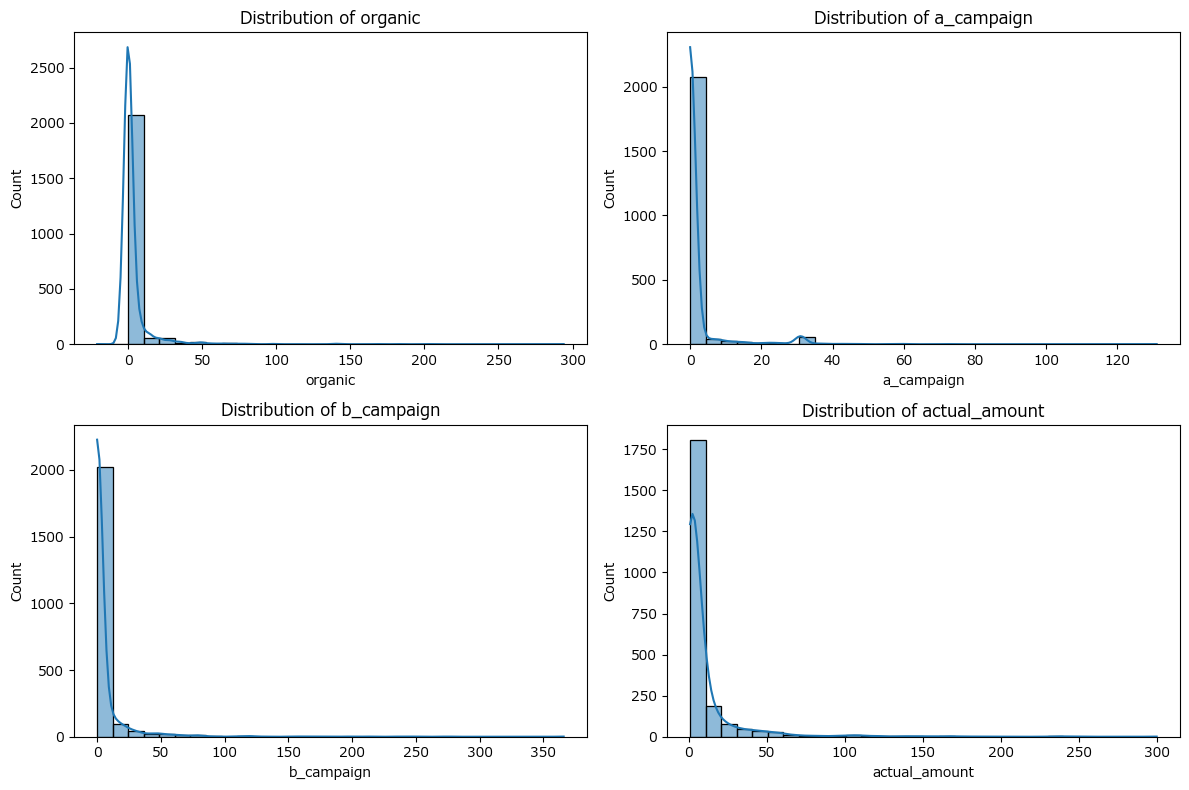

In [19]:
# ヒストグラムを描画
plt.figure(figsize=(12, 8))

columns = ["organic", "a_campaign", "b_campaign", "actual_amount"]

for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)  # 2行2列のサブプロット
    sns.histplot(df[col], bins=30, kde=True)  # KDE（滑らかな分布曲線）を追加
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


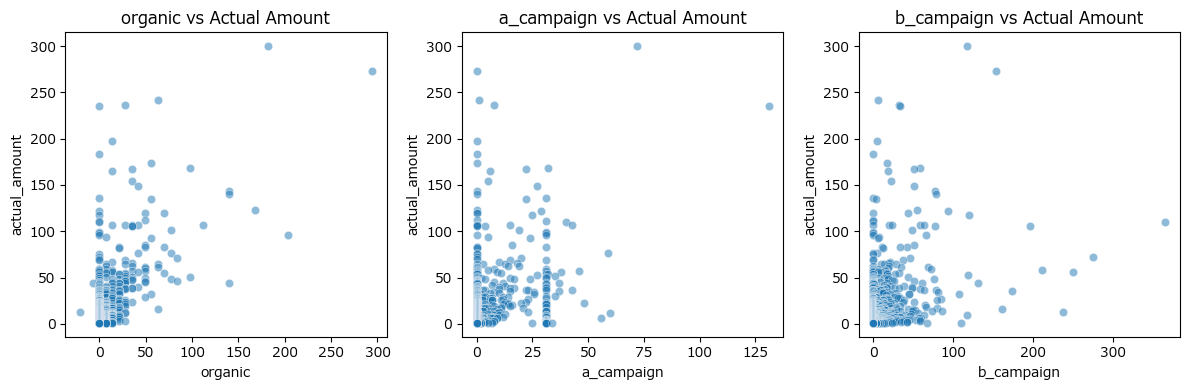

In [20]:
#散布図
plt.figure(figsize=(12, 4))

for i, col in enumerate(["organic", "a_campaign", "b_campaign"], 1):
    plt.subplot(1, 3, i)  # 1行3列のサブプロット
    sns.scatterplot(x=df[col], y=df["actual_amount"], alpha=0.5)
    plt.title(f"{col} vs Actual Amount")

plt.tight_layout()
plt.show()


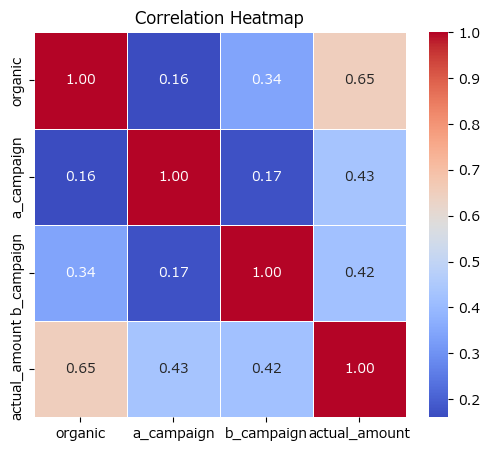

In [21]:
# 相関関係
plt.figure(figsize=(6, 5))
sns.heatmap(df[["organic", "a_campaign", "b_campaign", "actual_amount"]].corr(), 
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


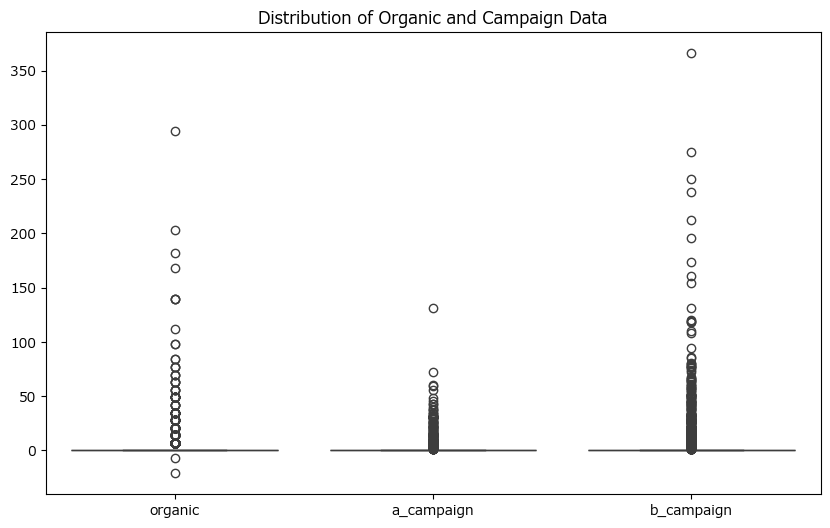

In [22]:
# キャンペーンの影響を箱ひげ図で確認
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[["organic", "a_campaign", "b_campaign"]])
plt.title("Distribution of Organic and Campaign Data")
plt.show()


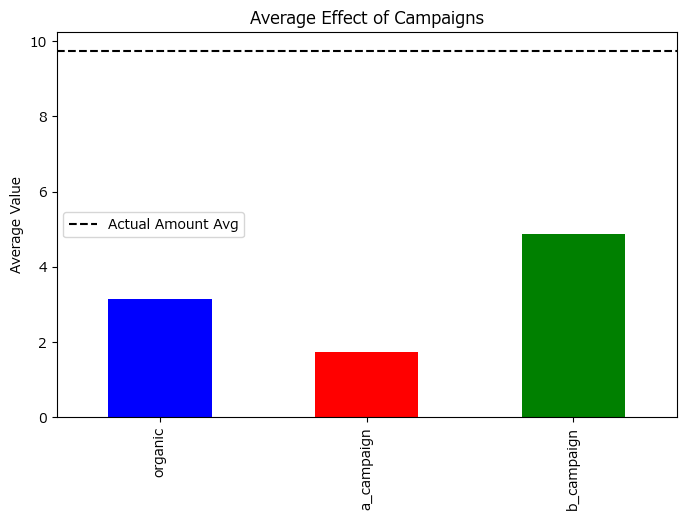

In [23]:
#キャンペーンが売上 (actual_amount) に与える影響を可視化。
campaign_effect = df[["organic", "a_campaign", "b_campaign", "actual_amount"]].mean()

plt.figure(figsize=(8, 5))
campaign_effect.drop("actual_amount").plot(kind="bar", color=["blue", "red", "green"])
plt.axhline(campaign_effect["actual_amount"], color="black", linestyle="--", label="Actual Amount Avg")
plt.title("Average Effect of Campaigns")
plt.ylabel("Average Value")
plt.legend()
plt.show()


In [24]:
#モデル構築
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df.columns
X = df[['organic', 'a_campaign', 'b_campaign']]
y = df['actual_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

print(lm.intercept_)
print(lm.coef_)

X_train.columns
cdf = pd.DataFrame(lm.coef_,X_train.columns,columns=['Coef'])
print(cdf)

4.172436893754876
[0.91094793 1.04429691 0.21193526]
                Coef
organic     0.910948
a_campaign  1.044297
b_campaign  0.211935


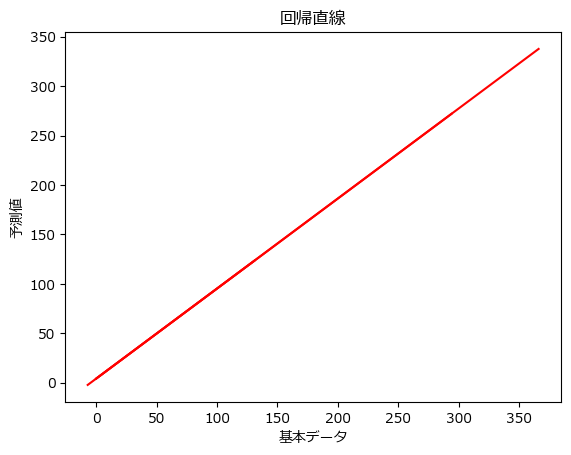

In [25]:
# lm.intercept_ は切片、lm.coef_ は係数（配列）
# 線形回帰のフィット直線を描画
x1 = np.linspace(X_train.min(), X_train.max(), 100)  # x 軸の範囲を生成
y1 = lm.intercept_ + lm.coef_[0] * x1  # organic切片と傾きで直線の y 値を計算
plt.plot(x1, y1, color='red')  # 直線を追加

# 凡例とタイトルを追加
plt.xlabel('基本データ')
plt.ylabel('予測値')
plt.title('回帰直線')
plt.show()

c:\Users\awse\anaconda3\envs\dataSci\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


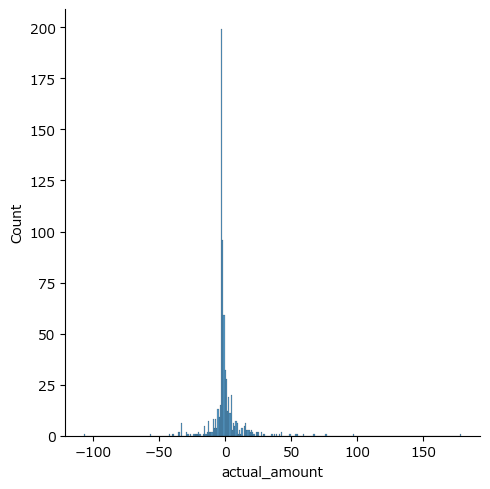

In [26]:
#残差分布図
predictions = lm.predict(X_test)
predictions
sns.displot((y_test-predictions))

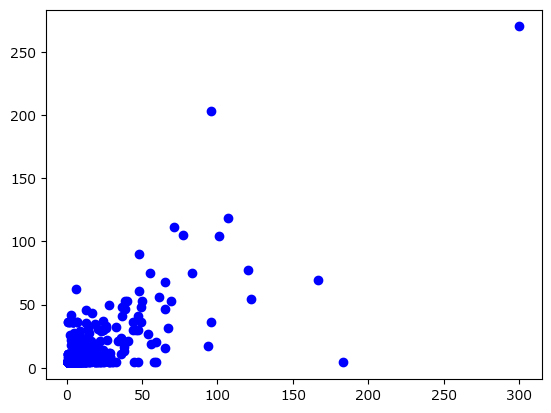

In [27]:
# 散布図を描画
plt.scatter(y_test, predictions, color='blue')

In [28]:
#決定係数
from sklearn.metrics import r2_score

# 実際の値 (y_test) と予測値 (predictions)
r2 = r2_score(y_test, predictions)
print(f"決定係数 (R²): {r2}")


決定係数 (R²): 0.5608771867316141
